In [217]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from gerrychain import Graph, GeographicPartition, Election, MarkovChain, tree, constraints
from functools import partial
from gerrychain.updaters import Tally, cut_edges
from gerrychain.metrics import polsby_popper
from gerrychain.proposals import recom
import os
from gerrychain.accept import always_accept

from candidate import Candidate

In [224]:
PROCESSED_SHAPEFILE_PATH = os.path.join(os.getcwd())
NC_PATH = os.path.join(PROCESSED_SHAPEFILE_PATH, "north carolina", "precinct_level_w_election.shp")
ITERATIONS = 100
SAFE_SEAT_THRESHOLD = 0.66
TOTAL_DISTRICTS = 13
FOUR_FOUR_FIVE = 3.25
FIVE_FIVE_THREE = 2.6
THRE_THREE_THREE_FOUR = 4.33

In [204]:
nc_graph = Graph.from_file(NC_PATH, ignore_errors=True)

/Users/alexisperezmendoza/Desktop/python-mggg/mggg/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/alexisperezmendoza/Desktop/python-mggg/mggg/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)


In [205]:
total_pop = sum(nc_graph.nodes[node]["TOTPOP"] for node in nc_graph.nodes)

candidate_D1 = Candidate("Democrat1", "Democratic")
candidate_D2 = Candidate("Democrat2", "Democratic")
candidate_D3 = Candidate("Democrat3", "Democratic")
candidate_D4 = Candidate("Democrat4", "Democratic")
candidate_D5 = Candidate("Democrat5", "Democratic")
candidate_R1 = Candidate("Republican1", "Republican")
candidate_R2 = Candidate("Republican2", "Republican")
candidate_R3 = Candidate("Republican3", "Republican")
candidate_R4 = Candidate("Republican4", "Republican")
candidate_R5 = Candidate("Republican5", "Republican")

In [206]:
partition_445 = tree.recursive_tree_part(nc_graph, [1, 2, 3], total_pop / FOUR_FOUR_FIVE, "TOTPOP", 0.01, 1)
partition_553 = tree.recursive_tree_part(nc_graph, [1, 2, 3], total_pop / FIVE_FIVE_THREE, "TOTPOP", 0.01, 1)
partition_3334 = tree.recursive_tree_part(nc_graph, [1, 2 ,3, 4], total_pop /THRE_THREE_THREE_FOUR, "TOTPOP", 0.01, 1)

nc_election = Election("CongressionalRace" , {"Democratic": "D_VOTES", "Republican": "R_VOTES"})

In [207]:

# Create a new partition with the election results
new_partition445 = GeographicPartition(nc_graph, assignment=partition_445, updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": nc_election
    })
new_partition553 = GeographicPartition(nc_graph, assignment=partition_553, updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": nc_election
    })

new_partition3334 = GeographicPartition(nc_graph, assignment=partition_3334, updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": nc_election
    })

In [212]:
ideal_pop445 = total_pop / FOUR_FOUR_FIVE
proposal445 = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop445, epsilon=.02, node_repeats=2)
compactness445 = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(new_partition445["cut_edges"])
)
pop_constraint445 = constraints.within_percent_of_ideal_population(new_partition445, 0.3)

ideal_pop553 = total_pop / FIVE_FIVE_THREE
proposal553 = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop553, epsilon=.02, node_repeats=2)
compactness553 = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(new_partition553["cut_edges"])
)
pop_constraint553 = constraints.within_percent_of_ideal_population(new_partition553, 0.4)

ideal_pop3334 = total_pop / THRE_THREE_THREE_FOUR
proposal3334 = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop3334, epsilon=.02, node_repeats=2)
compactness3334 = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(new_partition3334["cut_edges"])
)
pop_constraint3334 = constraints.within_percent_of_ideal_population(new_partition3334, 0.3)



In [225]:
# Print the population of each district
chain445 = MarkovChain(
    proposal=proposal445,
    constraints=[
        compactness445,
        pop_constraint445
    ],
    accept=always_accept,
    initial_state=new_partition445,
    total_steps=ITERATIONS
)

chain553 = MarkovChain(
    proposal=proposal553,
    constraints=[
        compactness553,
        pop_constraint553
    ],
    accept=always_accept,
    initial_state=new_partition553,
    total_steps=ITERATIONS
)

chain3334 = MarkovChain(
    proposal=proposal3334,
    constraints=[
        compactness3334,
        pop_constraint3334
    ],
    accept=always_accept,
    initial_state=new_partition3334,
    total_steps=ITERATIONS
)


In [266]:
master_dict = {"chain445": chain445, "chain355": chain553, "chain3334": chain3334}

dem_candidates = [candidate_D1, candidate_D2, candidate_D3, candidate_D4, candidate_D5]
rep_candidates = [candidate_R1, candidate_R2, candidate_R3, candidate_R4, candidate_R5]

chain_dict = {}
for link in master_dict:
    all_elections = []
    for step in master_dict[link]:
        election = {}
        for district in step["population"]:
            top_candidates = {} # Key = name of candidate, Value = number of votes
            for cand in dem_candidates:
                top_candidates[cand.get_name()] = 0
            for cand in rep_candidates:
                top_candidates[cand.get_name()] = 0
            total_reps = round((step["population"][district] / total_pop) * TOTAL_DISTRICTS)
            dem_votes = step["CongressionalRace"].votes("Democratic")[district-1]
            rep_votes = step["CongressionalRace"].votes("Republican")[district-1]
            weight = 1
            for cand in range(total_reps):
                top_candidates[rep_candidates[cand].get_name()] += (weight * rep_votes)
                top_candidates[dem_candidates[cand].get_name()] += (weight * dem_votes)
                weight -= .05
            election[district] = top_candidates
            
            for part in election:
                election[part] = dict(sorted(election[part].items(), key=lambda item: item[1], reverse=True))
        all_elections.append(election)
    chain_dict[master_dict[link]] = all_elections
        



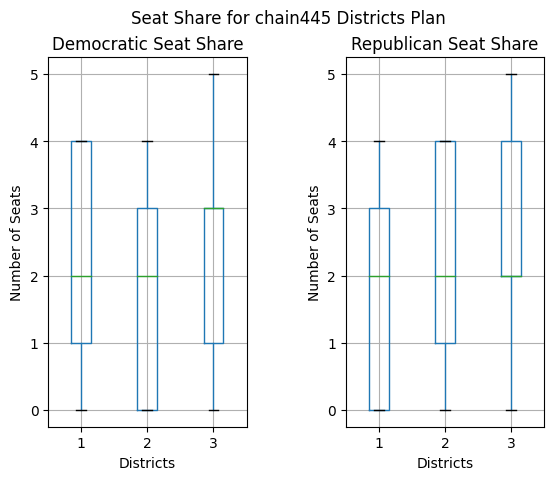

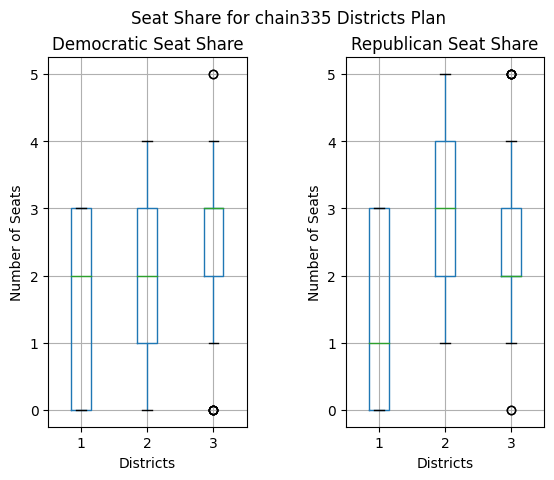

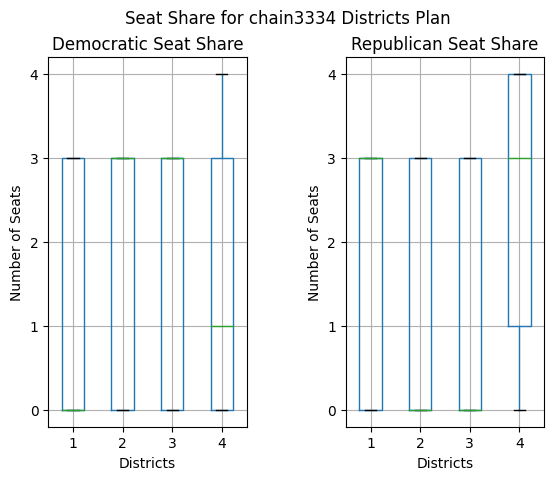

In [267]:


# Remove all candidates that have 0 votes
for link in master_dict:
    new_election = []
    for election in chain_dict[master_dict[link]]:
        new_election.append({})
        for district in election:
            new_election[-1][district] = {}
            for candidate in election[district]:
                if election[district][candidate] != 0:
                    new_election[-1][district][candidate] = election[district][candidate]
            

    for election in new_election:
        for district in election:
            # Remove half of the candidates
            election[district] = dict(list(election[district].items())[:int(len(election[district])/2)])
            # Sort districts by number of elements
            election[district] = dict(sorted(election[district].items(), key=lambda item: item[1], reverse=True))

    # Sort the districts by number of elements and re index them
    # District 3 should have the most candidates
    new_election = sorted(new_election, key=lambda x: len(x[len(x)]), reverse=True)
    for i in range(len(new_election)):
        new_election[i] = dict(sorted(new_election[i].items(), key=lambda x: len(x[len(x)-1]), reverse=False))
        new_election[i] = dict(enumerate(new_election[i].values(), start=1))
    chain_dict[master_dict[link]] = new_election
    
    dem_seatshare = []
    rep_seatshare = []
    for election in new_election:
        dem_dict = {}
        rep_dict = {}
        for district in election:
            # Get the number of repubicans and democrats
            num_dem = 0
            num_rep = 0
            for candidate in election[district]:
                if candidate[0] == "D":
                    num_dem += 1
                else:
                    num_rep += 1
            dem_dict[district] = num_rep
            rep_dict[district] = num_dem
        dem_seatshare.append(dem_dict)
        rep_seatshare.append(rep_dict)


    df_dem = pd.DataFrame(dem_seatshare)
    df_rep = pd.DataFrame(rep_seatshare)


    # Group both boxplots together
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    fig.suptitle("Seat Share for " + link + " Districts Plan")
    df_dem.boxplot(ax=ax1)
    ax1.set_title("Democratic Seat Share")
    ax1.set_xlabel("Districts")
    ax1.set_ylabel("Number of Seats")
    df_rep.boxplot(ax=ax2)
    ax2.set_title("Republican Seat Share")
    ax2.set_xlabel("Districts")
    ax2.set_ylabel("Number of Seats")
    # Add space between the two plots
    fig.subplots_adjust(wspace=0.5)

    # Plots only whole numbers

    plt.show()


In [ ]:
import json
data = {}

# TODO:
